# An Analysis of Four Different Formulations of Chalk on Grip Strength

Ethan Basingr and Jerry H. Yu

## Introduction

Climbing Chalk is commonly used to enhance grip strength in sports like rock climbing or powerlifting. Most commercial brands of climbing chalk are made with Magnesium Carbonate (MgCO3). However, Magnesium carbonate has a wide variety of crystal structures that can affect its ability to absorb water and other fluids. My friend Ethan spent months designing a new way to crystallize MgCO3, with the goal of creating a superior chalk compared to commercial brands. This report analyzes an experiment he conducted with a third friend to analyze his chalk to other brands. 

## Test Design

The experiment was conducted as an unbalanced block design. Practical constraints prevented easy swapping between chalks during a single test session, so chalks were tested sequentially across different days, introducing potential confounding. While eliminating this bias is impossible, two approaches were taken to address it in the final analysis. Mixed models were used to evaluate the data, as they are well-suited for situations where we want to model the effects of variables believed to be random (such as day). Basically, since we expect that day or person can affect grip strength, and because 1) we do not care about the specific effect of each individual person or day, and 2) we expect the effect to vary each time, a mixed model is most appropriate.

In [ ]:
# Set Up Python Enviroment
import math
import sys
import pkg_resources
import numpy as np
import pandas as pd
import os
import rpy2
%load_ext rpy2.ipython
import statsmodels
import statsmodels.formula.api as smf
import plotly.express as px

import git
repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)
print(os.getcwd())

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
c:\Users\Public\Documents\Personal_Projects\Ethan_Chalk_Project


In [92]:
%%R
# Set Up R Enviroment in Python
library(tidyverse)
library(lmtest)
library(here)
library(lme4) 
library(MASS)
library(MuMIn)
library(caret)
library(clubSandwich)
library(emmeans)
library(pbkrtest)
library(sjPlot)

# Data

The original data was not formatted in the way of a long table, so I used excel to clean the data. Several explanatory variables were encoded in color or order of the tables, so they needed to be made explicit. I used a series of formulas for that. Thus, I created long formats of the `Chalk_Results.xlsx` and `Randomized tests.xlsx` (`Chalk_Long.xlsm` and `Metadata.slsx`) and merged and created labels for them in python. Metatdata contains information on dates. 

Variables are:
- **Code:** A number from 1-24. In Excel, the color of this column indicates the date, and its value indicates whether the test used a control or chalk, and which treatment was applied. `Code` + `bChalk` form the key for `merging metadata` with `Chalk_Long`.
- **bChalk:** a number from 1-4 (1=FL. 2=Metolius, 3=Magdust, 4=Ethan's Chalk), not directly indicative of whether chalk was used. `Code` + `bChalk` form the key for merging metadata with `Chalk_long`.
- **Pinch_Order:** Order in which test was conducted, for each attempt (code number), the test was performed three times sequentially. `Pinch_Order` + `bChalk` + `Code` forms the primary key. 
- **Pinch:** The weight at which the board was pinched. 
- **Pull:** The weight just before the hand slipped. **Our dependent variable**. 
- **Chalk:** The actual chalk used, 0 is added for control. 
- **Used:** A Dummy variable for is chalk is used or not. U 
- **Person:** The person conducting the test, one intermediate and one advanced climber. 
- **Day:** The day when the test was conducted. Dates were, 10/30/2024,10/31/2024,11/4/2024,11/6/2024,11/8/2024,11/10/2024, and 11/14/2024. Last two were apparently "noticeably slippery". 
- **Day_Order:** The order in which the tests were conducted in the day. This was randomized. 

# Wrangling

The wrangling section is below. Mostly easy to clean, but some variables needed to be converted into factors. 

In [93]:
# Read in and Merge Data and Metadata
Chalk_Long = pd.read_excel('data/Raw/Chalk_Long.xlsm', sheet_name=1, header=0)
metadata = pd.read_excel('data/Raw/Metadata.xlsx', sheet_name=1, header=0)
Chalk = pd.merge(metadata, Chalk_Long, on=["Code","bChalk"], how='left')
#Chalk.to_csv('data/Processed/Chalk.csv', index=False)

# Convert Labels into factor variables for further analysis
Chalk["Chalk"] = Chalk["Chalk"].astype("category")
Chalk["Chalk"] = Chalk["Chalk"].cat.rename_categories(["None", "FL", "Metolius", "Magdust", "Ethan"])
Chalk["Pinch_Order"] = Chalk["Pinch_Order"].rank(method='dense')
Chalk["Day_Chalk"] = Chalk["Day"].astype("str") + "_" + Chalk["Chalk"].astype("str")
Chalk["Used"] = [0 if c== "None" else 1 for c in Chalk["Chalk"]]
Chalk["Used"] = Chalk["Used"].astype("category")
Chalk["Used"] = Chalk["Used"].cat.rename_categories(["None", "Chalk"])
Chalk["Person"] = Chalk["Person"].astype("category")
Chalk["Day"] = Chalk["Day"].astype("category")

In [94]:
# Now let us check that our wrangling worked as expected
%R -i Chalk
Chalk.info()
Chalk.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Code         576 non-null    int64   
 1   bChalk       576 non-null    int64   
 2   Day_Order    576 non-null    int64   
 3   Day          576 non-null    category
 4   Pinch        576 non-null    float64 
 5   Pull         576 non-null    float64 
 6   Pinch_Order  576 non-null    float64 
 7   Chalk        576 non-null    category
 8   Person       576 non-null    category
 9   Day_Chalk    576 non-null    object  
 10  Used         576 non-null    category
dtypes: category(4), float64(3), int64(3), object(1)
memory usage: 34.7+ KB


c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Day". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Person". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.



,Code,bChalk,Day_Order,Day,Pinch,Pull,Pinch_Order,Chalk,Person,Day_Chalk,Used
0,16,1,1,2024-10-30,4.202,34.6,1.0,None,1,2024-10-30_None,None
1,16,1,1,2024-10-30,4.117,31.9,2.0,None,1,2024-10-30_None,None
2,16,1,1,2024-10-30,4.154,31.9,3.0,None,1,2024-10-30_None,None
3,34,1,2,2024-10-30,4.088,41.1,1.0,FL,2,2024-10-30_FL,Chalk
4,34,1,2,2024-10-30,4.088,44.5,2.0,FL,2,2024-10-30_FL,Chalk


# EDA

Next Graphs to Visualize Key Variables

- First I will check the distributions of the numeric variables. 
- This will allow us to potentially see if the data could have issues that violate the assumptions of mixed models that need to be addressed. 

In [ ]:
# Graph Pinch
pinchist = px.histogram(Chalk,x="Pinch",
                        title = "Distribution of Pinch Strength",
                        nbins = 20)
pinchist.update_layout(
    title = {
        "text":"Distribution of Pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pinchist.show()
# good coverage, no noticable outliers

Notes:
- At lower pinch strength, There was more control, so more values were closer to exactly 1 lb or exactly 2lbs. Still the distribution is pretty uniform. 

In [7]:
# Graph Pull
pullhist = px.histogram(Chalk,x="Pull",
                        title = "Distribution of Pull Strength")
pullhist.update_layout(
    title = {
        "text":"Distribution of Pull Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pullhist.show()
#right tail, might need normalization

- Very significant right skew. This is a sign of nonnormality. 

In [8]:
# Now Graph Relation Between Pinch and Pull
pinchpull = px.scatter(Chalk, x = "Pinch", y = "Pull",title = "Kilograms Pulled by pinch Strength")
pinchpull.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
pinchpull.show()

#nice and Linear, but maybe not homoscedastic

- This shows a mostly linear relationship by very homoscedastic data. 

Now we will split this relationship by some of the categorical variables to evaluate impact. 

In [ ]:
# Type of Chalk
byChalk = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Chalk", title = "Kilograms Pulled by pinch Strength")
byChalk.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byChalk.show()

# Very Nice Separation for Control and using Chalk, between chalks is less clear. 
byDate = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Day", title = "Kilograms Pulled by pinch Strength")
byDate.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byDate.show()
# There are not that clear of patterns (seperation) in date. 

- The patterns found in chalk are a good sign, likewise the lack of a clear pattern in date. 

In [10]:
# Person
byPerson = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Person", title = "Kilograms Pulled by pinch Strength")
byPerson.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Strength<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byPerson.show()

# Clear Difference by person, as expected

-Very Clear separation by person. 

In [ ]:
# Test Pinch Order
byOrder = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Pinch_Order", title = "Kilograms Pulled by pinch Order")
byOrder.update_layout(
    title = {
        "text":"Kilograms Pulled by pinch Order<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byOrder.show()

# Very random, quite nice

# Test Day Order
byDay = px.scatter(Chalk, x = "Pinch", y = "Pull", color = "Day_Order", title = "Kilograms Pulled by Day_Order")
byDay.update_layout(
    title = {
        "text":"Kilograms Pulled by Day_Order<br><sup>by Jerry Yu</sub>",
        "x":0.5,
        "xanchor":"center",
        "yanchor":"top"
    }
)
byDay.show()

# Generally Also Pretty Random

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Day". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\rpy2\robjects\pandas2ri.py:65: UserWarning:

Error while trying to convert the column "Person". Fall back to string conversion. The error is: Converting pandas "Category" series to R factor is only possible when categories are strings.



- Generally no potentilaly problematic patters in pinch order and day order. 

### Graph Summary
- Our exploratory data analysis (EDA) generally shows good separation based on chalk type and person, but negligible effects from day order and pinch order.
- However, we cannot avoid confounding between chalk type and day.
- The data is also somewhat group unbalanced, with the control group being overrepresented. Linearity appears satisfactory, but homoscedasticity and normality do not.
     

## Assumption Testing

Now we will test the assumptions needed for Linear Mixed Models. Confounding by chalk type and day is inevitable and could compromise our analysis. Therefore, for this assumption testing, I will sidestep this confounding by focusing on whether chalk was used at all, rather than the specific type (using the `Used` variable instead of `Chalk`). This will result in control and treatment groups of roughly equal size and remove confounding related to chalk type. The goal of this analysis is to 1) determine the best structure for random effects and 2) test if model assumptions are violated, allowing us to correct for these violations in the actual analysis.

In [96]:
%%R -o resid -o predict
Chalk$Day = as.factor(Chalk$Day)
Chalk$Person = as.factor(Chalk$Person)
# Now we will test assumptions needed for Linear Mixed Models and the random effects structure

# First Test Random Effects Matrix. 
# First Fit a Full Model of All Relevant Variables and a model without Date to Test Significance of Date
twoeffects = lmer(Pull~Pinch*Used + (1|Person) + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
nested = lmer(Pull~Pinch*Used + (1 | Person:Day),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
indep = lmer(Pull~Pinch*Used + (1 | Day) + (1|Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail) 
nodate = lmer(Pull~Pinch*Used + (1|Person), 
            data = Chalk)
print(AIC(twoeffects, nested, indep, nodate))
print(BIC(twoeffects, nested, indep, nodate))

# Very Very Siginificant Effect on Fit, nested random better than crossed random
resid = summary(nested)$residuals
predict = predict(nested)

# Test Practical Significance with Effect Size/Fit
print("Random Intercepts for Person and For Each Person by Day Group")
r.squaredGLMM(twoeffects) |> print()
print("Random Intercept for Person by Day Group")
r.squaredGLMM(nested) |> print()
print("Random Intercept for Person and Day")
r.squaredGLMM(indep) |> print()
print("Random Intercept for Person Only")
r.squaredGLMM(nodate) |> print()

           df      AIC
twoeffects  7 3556.291
nested      6 3555.706
indep       7 3576.381
nodate      6 3657.689
           df      BIC
twoeffects  7 3586.784
nested      6 3581.843
indep       7 3606.874
nodate      6 3683.826
[1] "Random Intercepts for Person and For Each Person by Day Group"
           R2m       R2c
[1,] 0.8914495 0.9276219
[1] "Random Intercept for Person by Day Group"
           R2m       R2c
[1,] 0.8911071 0.9276359
[1] "Random Intercept for Person and Day"
           R2m       R2c
[1,] 0.8876317 0.9241147
[1] "Random Intercept for Person Only"
           R2m       R2c
[1,] 0.8761392 0.9104231


To evaluate the quality of our random effects matrices I used two types of metrics: AIC/BIC and Conditional R^2. 

- From AIC and BIC (Basically comparing how likely our data would be assuming that our model was correct while accounting for increasing number of variables) we see that the model that includes the only nested Person Date component is the best model. 
- However we see from the conditional coefficient of determination (basically an approximation of how much of the variability of the data can be explained by our model) that the effects are very small (0.92 vs 0.93), indicating that Date probably does not have  much of an effect on explaining the variation in our data. This is good because it might indicate that confounding does not have much of an effect. 

Thus, I decided to use the Nested Effects only random effects matrices for all future analysis. 

In [13]:
# Test Residuals
testrelresid = px.scatter(x = predict,
                          y = resid,
                          title = "Residuals",
                          labels = {"x": "Predicted Values", "y": "Residuals"})
testrelresid.show()
# Very Heteroscedastic

- Very heteroscedastic. Now Test Normality


	Shapiro-Wilk normality test



data:  residuals(nested)
W = 0.98422, p-value = 6.904e-06



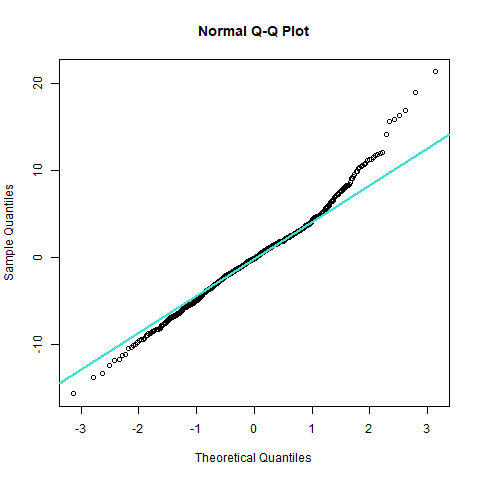

In [14]:
%%R
qqnorm(residuals(nested))
qqline(residuals(nested),col="turquoise",lwd=2)
# Towards the Top seems nonormal
shapiro.test(residuals(nested))
# Also Nonnormal

- Also very nonnormal. 

We will need to address nonnormality and heteroscedasticity in our subsequent analysis. 

# Data Analysis Plan

### Summary
- Use linear mixed models to model the effect of chalk and pinch strength on pull strength, with Person and Date as random effects. Day Order and Pinch Order were not used for this model because Day Order was randomized, and Pinch Order was not very significant in the EDA. 
- Perform pairwise contrasts between types of chalk or combinations of Chalk and day. 

### Addressing Data Abnormalities
- For model selection, I used bootstrapped Likelihood Ratio Tests. Basically, I compared how likely the data was with a larger model and a smaller model with one or more explanatory variables removed. Instead of assuming a specific distribution, which would require our assumptions be met, I resampled out data repeatedly and used the values of my subsamples to get a distribution. This reduced the impact of heteroscedasticity and nonnormality for model selection. 
- To address non-normality, I tried a variety of different transformations. The one that worked the best was a log transform of the independent variable (Pinch). This did not entirely correct nonnormality, but the sample size was large enough that felt that the CLT would apply.
- To address heteroscedasticity, I used robust sandwich estimators for means comparison. 
- I tried two approaches to address confounding. 

1. Incorporate: Fit on the model with the interaction of Date and Chalk Type. This Removes the Confounding but makes interpreting the final results very difficult. Additionally, since the number of observations for certain groups is small (9 observations per subgroup), the ability to make statistically significant inferences is impaired. 

1. Ignore: Fit model with the same random effects structure from above. While This does not address confounding, we saw from the conditional coefficient of determination the effect of Date on overall model fit was negligible, so I felt confident in that.


## Part 1: Chalk vs No Chalk

I first wanted to test the fixed effect of Chalk vs. No Chalk. The formula for this approach is given as. 

$$
y = \bm{X}\beta + \bm{Y}u + \epsilon
$$

- where $y$ is a vector of pull strength.
- $\bm{X}$ is a matrix of fixed effects (intercept, `log(Pinch)`, `Used`, and their interaction if used in the model).
- $\beta$ is a vector of fixed effect coefficients. 
- $\bm{Y}$ is a matrix of random effects.
- u is a vector of random effect coefficients. u~$N(0,\sigma^2_{Person:Day})$
- $\epsilon$ is a matrix of residual effects, $\epsilon$ ~ $N(0,\sigma^2)$

## Model Selection

In [108]:
%%R
# All interaction Terms
fullnest = lmer(Pull~log(Pinch) + Used + log(Pinch):Used + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)
# No Interaction
partial = lmer(Pull~log(Pinch) + Used + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)
# No Chalk
partial2 = lmer(Pull~log(Pinch) + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)

boot1 = PBmodcomp(
  fullnest,
  partial,
  nsim = 1000,
  seed=42
)
boot2 = PBmodcomp(
  partial,
  partial2,
  nsim = 1000,
  seed=42
)

boot1 |> print()
boot2|> print()

r.squaredGLMM(fullnest) |> print()
r.squaredGLMM(partial) |> print()
r.squaredGLMM(partial2) |> print()


Bootstrap test; time: 12.33 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Used + log(Pinch):Used + (1 | Person:Day)
Pull ~ log(Pinch) + Used + (1 | Person:Day)
         stat df   p.value    
LRT    69.127  1 < 2.2e-16 ***
PBtest 69.127     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Bootstrap test; time: 11.58 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Used + (1 | Person:Day)
Pull ~ log(Pinch) + (1 | Person:Day)
         stat df   p.value    
LRT    239.97  1 < 2.2e-16 ***
PBtest 239.97     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
           R2m       R2c
[1,] 0.8393619 0.8770216
           R2m       R2c
[1,] 0.8242217 0.8617552
         R2m       R2c
[1,] 0.74882 0.7885454


- Testing the fixed effects shows that `Used` and `log(Pinch):Used` both were very significant statistically. 
- However the marginal coefficient of determination (R2m) did not change much between models with and without the interaction term.
- To further investigate, I took a look at the summary of fixed effect coefficients. 

In [109]:
%%R
summary(fullnest)$coefficients |> print()
summary(partial)$coefficients |> print()

                       Estimate Std. Error    t value
(Intercept)          -0.6794263  1.3537773 -0.5018745
log(Pinch)           24.2653868  0.7180147 33.7951098
UsedChalk             0.4763611  1.2750496  0.3736020
log(Pinch):UsedChalk  8.4465599  0.9876675  8.5520279
            Estimate Std. Error   t value
(Intercept) -5.92590  1.2339728 -4.802294
log(Pinch)  28.74690  0.5215605 55.117102
UsedChalk   10.27058  0.5954018 17.249829


- So, looking at fixed effect coefficients gives me a bit more understanding of what is happening. 
- It seems like the effect of using chalk is very dependent on pinch strength. 
- On average using chalk increased pull strength by 10.3 pounds but looking more closely this increase in strength was more noticeable when pinch strength was weaker. 
    - An increase in 1 percent of pinch strength (ie you pinch 1.01 lbs instead of 1 lb or 2.02 lbs instead of 2 lbs) increase lbs pulled by 0.084 lbs. 
- This makes sense, as if chalk increases grip strength, this effect should be more prominent when grip strength is weaker. 

## Part Two: Remove Confounding by Using Date-Chalk Combinations

If we simply treat days as fixed variables, with each unique date/chalk combination as its own independent treatment, we remove confounding entirely. 

The model formula remains largely the same, with the only difference found in the design matrix $\bm{X}$. Instead of using `Used` as a predictor, this model utilizes `Chalk`, resulting in a larger number of columns and coefficients.

In [110]:
%%R
# Fit a full model with the Confounded Chalk and Day Variables
# All interaction Terms
fullnest = lmer(Pull~log(Pinch) + Day_Chalk + log(Pinch):Day_Chalk + (1 | Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)
# No Interaction Terms
partial = lmer(Pull~log(Pinch) + Day_Chalk + (1 | Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)
# No Day*Chalk Variable
partial1 = lmer(Pull~log(Pinch) + (1 | Person),
                data = Chalk,
                REML = FALSE,
                na.action=na.fail)

# Test Statistical Significance with Boostrapped Model Comparison
boot1 = PBmodcomp(
  fullnest,
  partial,
  nsim = 1000,
  seed=42
)
boot2 = PBmodcomp(
  partial,
  partial1,
  nsim = 1000,
  seed=42
)

boot1 |> print()
boot2|> print()

# Test Practical Significance with Effect Size/Fit
r.squaredGLMM(fullnest) |> print()
r.squaredGLMM(partial) |> print()
r.squaredGLMM(partial1) |> print()


Bootstrap test; time: 13.74 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Day_Chalk + log(Pinch):Day_Chalk + (1 | Person)
Pull ~ log(Pinch) + Day_Chalk + (1 | Person)
         stat df   p.value    
LRT    146.58 16 < 2.2e-16 ***
PBtest 146.58     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Bootstrap test; time: 11.47 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Day_Chalk + (1 | Person)
Pull ~ log(Pinch) + (1 | Person)
         stat df   p.value    
LRT    376.16 16 < 2.2e-16 ***
PBtest 376.16     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
           R2m      R2c
[1,] 0.8899425 0.906717
          R2m       R2c
[1,] 0.864733 0.8792501
           R2m       R2c
[1,] 0.7531656 0.7674678


- For our bootstrapped LRTs, the interaction of `Day_Chalk` and Pinch as well as the `Day_Chalk` variable itself are significant. 
- However, the marginal coefficient of determination – the proportion of variance in the model explained solely by the fixed effects – is small when comparing the model with the interaction term to the model without it. That means the practical difference in how well the model explains the data for the model with the interaction between `Pinch` and `Day_Chalk` is negligible. 
- This fits the pattern from above when just `Used` was used instead of type of chalk, suggesting that the benefit of using chalk to improve pull strength is largely dependent on pinch strength.

Thus for ease of interpretation of an already harder to interpret model, I will use the model without the interaction term, but keep in mind that effects of using chalk are likely more prominent with weaker grips. 

Next we Check Our Contrasts

In [115]:
%%R -o emmplot -o contrasts
finalmodel = lmer(Pull~log(Pinch) + Day_Chalk + (1 | Person),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)
# Now we do Mean Comparisons
corCov = vcovCR(finalmodel,type="CR2")
robustemm = emmeans(finalmodel, specs = ~Day_Chalk, vcov = corCov, type = "response")
contrasts = summary(pairs(robustemm))
emmplot = summary(robustemm, infer = TRUE)

R[write to console]: Kenward-Roger method can't be used with user-supplied covariances



In [116]:
# type(emmplot)
# type(contrasts)

emmplot = emmplot.sort_values("lower.CL").reset_index(drop=True)
emmplot["mag"] = emmplot["upper.CL"] - emmplot["emmean"]
# Create basic plot
arrow1 = px.scatter(
        emmplot,
        y='Day_Chalk',
        x='emmean',
        error_x = "mag"
        )
# Update layout
arrow1.update_layout(
        title='Chalk_Date Effects with 95% CI',
        xaxis_title='Estimated Marginal Mean',
        yaxis_title='Treatment'
    )
arrow1.show()


In [17]:
sigcontrasts = contrasts[contrasts["p.value"] < 0.05]
sigcontrasts.head()

,contrast,estimate,SE,df,t.ratio,p.value
2,(2024-10-30_FL) - (2024-10-31_FL),-6.985374,1.949090,557.222378,-3.583915,3.516042e-02
5,(2024-10-30_FL) - (2024-11-04_Metolius),-8.291978,0.366185,557.138535,-22.644249,4.494762e-10
7,(2024-10-30_FL) - (2024-11-06_Metolius),1.468606,0.186823,557.003330,7.860967,4.518564e-10
10,(2024-10-30_FL) - (2024-11-08_Metolius),5.173192,1.456721,557.085199,3.551258,3.913229e-02
11,(2024-10-30_FL) - (2024-11-08_None),11.922337,1.040257,557.202531,11.460954,4.498204e-10


- As seen above, when looking at combinations of Date and Chalk, the ability to make meaningful contrasts is difficult. 
- Out of the 136 possible contrasts produced by pairs, 50 were significant. 
- Trends among these significant contrasts revealed that FL and Metolius Chalk combinations generally outperformed the no-chalk option on most days, and Mag Dust on November 10th.
- However, the exceptionally high variability associated with later testing dates made meaningful comparisons from being made. 

Therefore, due to the differences in variability of chalk across days, it is almost impossible to draw very good conclusions from this model other than that using chalk (Metolius, FL) on earlier days was better than not using chalk at all. 

## Approach Number Two: Ignore Confounding

This approach accepts the confounding in order to get more understandble results comparing types of chalk. 

Again, the only major difference in the model is in the design matrix, where `Chalk` was used instead of `Day_Chalk` or `Used`. 

In [117]:
%%R
# All interaction Terms
fullnest = lmer(Pull~log(Pinch) + Chalk + log(Pinch):Chalk + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)
# No Interaction
partial = lmer(Pull~log(Pinch) + Chalk + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)
# No Chalk
partial2 = lmer(Pull~log(Pinch) + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)

boot1 = PBmodcomp(
  fullnest,
  partial,
  nsim = 1000,
  seed=42
)
boot2 = PBmodcomp(
  partial,
  partial2,
  nsim = 1000,
  seed=42
)

boot1 |> print()
boot2|> print()

r.squaredGLMM(fullnest) |> print()
r.squaredGLMM(partial) |> print()
r.squaredGLMM(partial2) |> print()

Bootstrap test; time: 11.13 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Chalk + log(Pinch):Chalk + (1 | Person:Day)
Pull ~ log(Pinch) + Chalk + (1 | Person:Day)
         stat df   p.value    
LRT    81.821  4 < 2.2e-16 ***
PBtest 81.821     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Bootstrap test; time: 10.65 sec; samples: 1000; extremes: 0;
large : Pull ~ log(Pinch) + Chalk + (1 | Person:Day)
Pull ~ log(Pinch) + (1 | Person:Day)
         stat df   p.value    
LRT    251.59  4 < 2.2e-16 ***
PBtest 251.59     0.000999 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
           R2m       R2c
[1,] 0.8384591 0.8830831
           R2m       R2c
[1,] 0.8215319 0.8665234
         R2m       R2c
[1,] 0.74882 0.7885454


- Again we observe statistically significant interactions that have minimal impact on model fit. 
- However, this time I did explore the effect of pinch strength on chalk performance by visualizing it using an interaction plot.

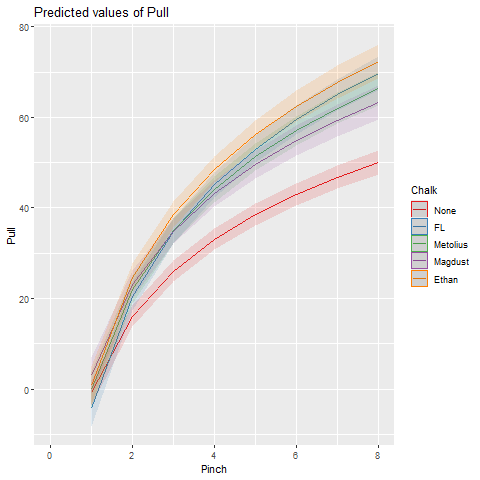

In [119]:
%%R
plot_model(fullnest, 
           type = "pred", 
           terms = c("Pinch", "Chalk"))


- The interaction plot shows some crossover - lines crossing over, indicating potentially that different treatments are better at different ranges of Pinch Strength - between No chalk and FL but these effects do not seem significant after pinch strength exceeds 1.5 lbs. 
- While a clear separation exists between using chalk and not using chalk, this is not the case among the four chalk types tested. While there is also crossover between the four types of chalk, their confidence intervals (CIs) largely overlap. 
- Based on these results, while there is some potential interaction between the levels of Chalk as pinch strength increased, our experiment does not seem to capture the differences well enough to make good conclusions about them. 
- Therefore, I will omit interaction terms to produce more interpretable results.

In [120]:
%%R -o ccontrasts -o cemmplot 
finalmodel2 = lmer(Pull~log(Pinch) + Chalk + (1 | Person:Day),
                data = Chalk,
                REML = TRUE,
                na.action=na.fail)


# Now we do Mean Comparisons
ccorCov = vcovCR(finalmodel2,type="CR2")
crobustemm = emmeans(finalmodel2, specs = ~Chalk, vcov = ccorCov, type = "response")
ccontrasts = summary(pairs(crobustemm))
cemmplot = summary(crobustemm, infer = TRUE)

R[write to console]: Kenward-Roger method can't be used with user-supplied covariances



In [121]:
cemmplot = cemmplot.sort_values("lower.CL").reset_index(drop=True)
cemmplot["mag"] = cemmplot["upper.CL"] - cemmplot["emmean"]
# Create basic plot
arrow2 = px.scatter(
        cemmplot,
        y='Chalk',
        x='emmean',
        error_x = "mag"
        )
# Update layout
arrow2.update_layout(
        title='Chalk Effects with 95% CI',
        xaxis_title='Estimated Marginal Mean',
        yaxis_title='Treatment'
    )
arrow2.show()


In [21]:
ccontrasts

,contrast,estimate,SE,df,t.ratio,p.value
1,None - FL,-9.767675,3.772330,549.410985,-2.589295,0.073715
2,None - Metolius,-9.081619,3.622454,556.738865,-2.507035,0.090495
3,None - Magdust,-8.845868,2.689925,569.988604,-3.288519,0.009411
4,None - Ethan,-13.440060,3.920270,564.058799,-3.428351,0.005855
5,FL - Metolius,0.686056,5.022044,523.602789,0.136609,0.999921
6,FL - Magdust,0.921807,4.549730,540.165173,0.202607,0.999624
7,FL - Ethan,-3.672385,5.322730,527.462871,-0.689944,0.958635
8,Metolius - Magdust,0.235752,4.286318,558.557417,0.055001,0.999998
9,Metolius - Ethan,-4.358441,5.309620,537.303669,-0.820857,0.924177
10,Magdust - Ethan,-4.594192,4.402001,565.269301,-1.043660,0.834888


- This Output is now a lot more interpretable. 
- Only 2 p values for contrasts are significant at p = 0.05, Magdust and Ethan Chalk compared to none. 
- Essentially, this means Magdust and Ethan's Chalk are significantly better than no chalk according to our data, but that all four chalks are not significantly different from each other, and FL and Metolius are not significantly different from No Chalk. 

# Conclusions

From this experiment and subsequent data analysis I would draw three conclusions. These are below: 

1. **Chalk Improves Performance:** The use of chalk consistently improved performance. Coefficients for chalk usage were positive in models both with and without interaction terms, indicating a statistically significant benefit. 
2. **Analyzing The Chalk x Day Combinations is Very difficult:** However, in general this we found that Metolius and FL chalks on earlier days outperformed using no chalk on most days and some chalks or other days. Later days were more variable. 
3. **Results when Ignoring Confounding:** Modeling chalk type with day as a random effect—while acknowledging potential confounding—produced more understandable results, namely that Ethan's Chalk and Magdust outperformed no chalk, but that we did not detect significant differences between the four chalks.
     
Overall, this study showed a clear benefit to using chalk, particularly with weaker pinch strengths. This effect size was robust and consistently observed across all models. However, experimental design limitations complicated comparisons between chalk types. The confounding of date and chalk type—due to the specific chalks tested on each day—precluded a separation of their individual effects without making potentially invalid assumptions.

If we simply treat each chalk day combination as its own group, we are left with difficult to understand overlapping results due to the meaninglessness of date for future analysis and the lack of power from smaller groups. Meanwhile, treating date as a random variable relies on the assumption that observed overlaps between control and treatment groups across dates are generalizable to the entire dataset—an assumption that remains unproven. This method gives better power and more understandable results, but is still does not find significant differences in the quality of the four chalk types.  This is partially attributable to the overrepresentation of the control group in the analysis, resulting in fewer observations for each treatment group decreasing power. Furthermore, the lack of double blinding in this study introduces a potential source of bias.

For a first attempt at an experimental design, this project was strong. Future work could focus on retesting these chalk types using a randomized complete block design (RCBD) or a Latin square, which would eliminate confounding, perhaps enabled by better cleaning protocols or by using larger blocks each day (testing two types of chalk instead of one type plus control). It has been super fun to work on this project and I am glad to have done it. 

Thanks for Reading! Have a Great Day. 

# Addendum

Here are the versions of python and R, along with their packages/libraries that I used. 

In [122]:
%%R
sessionInfo()

R version 4.4.2 (2024-10-31 ucrt)
Platform: x86_64-w64-mingw32/x64
Running under: Windows 11 x64 (build 22631)

Matrix products: default


locale:
[1] English_United States.1252

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] sjPlot_2.8.17       pbkrtest_0.5.3      emmeans_1.10.7     
 [4] clubSandwich_0.5.11 caret_7.0-1         lattice_0.22-6     
 [7] MuMIn_1.48.4        MASS_7.3-64         lme4_1.1-36        
[10] Matrix_1.7-1        here_1.0.1          lmtest_0.9-40      
[13] zoo_1.8-12          lubridate_1.9.4     forcats_1.0.0      
[16] stringr_1.5.1       dplyr_1.1.4         purrr_1.0.4        
[19] readr_2.1.5         tidyr_1.3.1         tibble_3.2.1       
[22] ggplot2_3.5.1       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] Rdpack_2.6.2         pROC_1.18.5          sandwich_3.1-1      
 [4] rlang_1.1.5  

In [126]:
print("Python version:", sys.version)

installed_packages = pkg_resources.working_set
for pkg in sorted(installed_packages, key=lambda p: p.project_name.lower()):
    print(pkg.project_name, pkg.version)

Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:20:11) [MSC v.1938 64 bit (AMD64)]
annotated-types 0.7.0
anyio 4.9.0
asttokens 3.0.0
attrs 24.3.0
autocommand 2.2.2
backports.tarfile 1.2.0
beautifulsoup4 4.12.3
bleach 6.2.0
Bottleneck 1.4.2
Brotli 1.0.9
certifi 2025.1.31
cffi 1.17.1
charset-normalizer 3.3.2
colorama 0.4.6
comm 0.2.2
contourpy 1.3.1
cycler 0.11.0
debugpy 1.6.7
decorator 5.1.1
defusedxml 0.7.1
et-xmlfile 1.1.0
exceptiongroup 1.2.2
executing 2.1.0
fastjsonschema 2.20.0
filelock 3.18.0
fonttools 4.55.3
fsspec 2025.3.0
gitdb 4.0.7
GitPython 3.1.43
h11 0.14.0
httpcore 1.0.7
httpx 0.28.1
idna 3.7
imageio 2.37.0
imageio-ffmpeg 0.6.0
importlib-metadata 8.5.0
importlib-resources 6.4.0
inflect 7.3.1
ipykernel 6.29.5
ipython 8.30.0
jaraco.collections 5.1.0
jaraco.context 5.3.0
jaraco.functools 4.0.1
jaraco.text 3.12.1
jedi 0.19.2
jinja2 3.1.5
jsonschema 4.23.0
jsonschema-specifications 2023.7.1
jupyter-client 8.6.3
jupyter-core 5.7.2
jupyterlab-pygments 0.

In [22]:
# # Add to top of notebook
# import plotly.io as pio
# pio.renderers.default = "notebook_connected"